In [1]:
import dask.array as da
from dask import delayed
import napari 
import numpy as np
from fst.io import read
from pathlib import Path
import zarr

import matplotlib.pyplot as plt
import SimpleITK as sitk
from distributed import Client
from fst.distributed import get_jobqueue_cluster
import napari
%gui qt

In [2]:
def sitkreg(fixed, moving, apply=False):
    fixed, moving = sitk.GetImageFromArray(fixed), sitk.GetImageFromArray(moving)
    
    reg = sitk.ImageRegistrationMethod()
    reg.SetMetricAsMeanSquares()
    reg.SetOptimizerAsRegularStepGradientDescent(4.0, .01, 200 )
    reg.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
    reg.SetInterpolator(sitk.sitkLinear)
    out_tx = reg.Execute(fixed, moving)
    
    return out_tx

def sitkapply(fixed, moving, tx):
    fixed, moving = sitk.GetImageFromArray(fixed), sitk.GetImageFromArray(moving)
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed);
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetTransform(tx)
    out = sitk.GetArrayFromImage(resampler.Execute(moving))
    
    return out

In [3]:
def align_dipy(
    fixed,
    moving,
    metric_sampling=1.0,
    factors=(4, 2, 1),
    level_iters=(1000, 1000, 1000),
    sigmas=(8, 4, 0),
    mode='translation'):
 
    from dipy.align.transforms import TranslationTransform2D, AffineTransform2D
    from dipy.align.imaffine import AffineRegistration, MutualInformationMetric

    metric = MutualInformationMetric(32, metric_sampling)
    affreg = AffineRegistration(
        metric=metric,
        level_iters=level_iters,
        sigmas=sigmas,
        factors=factors,
        verbosity=0,
    )

    if mode == 'translation':
        transform = TranslationTransform2D()
    if mode == 'affine': 
        transform = AffineTransform2D()
        
    tx = affreg.optimize(fixed, 
                         moving, 
                         transform, 
                         params0=None,
                         starting_affine='mass')

    return tx

def filt(im):
    from skimage.filters import threshold_local
    from scipy.ndimage.filters import median_filter
    import numpy as np
    
    if im.ndim > 2:
        im_ = im.squeeze()
    else:
        im_  = im
    medfilt_size = 3
    perc = 90
    block_size = np.min(im_.shape) // 10
    if block_size % 2 == 0:
        block_size += 1
           
    thresh = threshold_local(im_, block_size=block_size)
    im_bgr = im_-thresh
    result = im_bgr * (im_bgr > np.percentile(im_bgr, perc))    
    result = median_filter(result, size=medfilt_size)
    if im.ndim > 2:
        result = np.expand_dims(result, 0)
    return result

def resizer(im, factors):
    import numpy as np
    from skimage.transform import resize
    new_shape = np.array(im.shape) // np.array(factors)
    if not np.array_equal(new_shape, np.array(im.shape)):
        mode='constant'
        cval = im.min()
        preserve_range=True
        result = resize(im, output_shape=new_shape, mode=mode,preserve_range=preserve_range, cval=cval).astype('float32')
    else:
        result = im
        
    return result

def shifter(data, shifts, block_id=None, order=1, cval=0.0):  
    from scipy.ndimage.interpolation import shift
    shifts_ = (0, *shifts[block_id[0]])   
    return shift(data, shifts_, order=order, cval=cval).astype('float32')

def mismatch(im1, im2, metric='mse'):
    import numpy as np
    from skimage.metrics import mean_squared_error, structural_similarity
    # sum of squared errors between images
    if metric == 'pearson':
        result = np.corrcoef(im1.ravel(), im2.ravel())[0,1]
    elif metric == 'mse':
        result = mean_squared_error(im1, im2)
    elif metric == 'ssim':
        result = structural_similarity(im1, im2)

    return result 

def pairwise(func, data, axis):
    from dask import delayed
    from dask.array import rollaxis
    rolled = rollaxis(data, axis)
    delf = delayed(func)
    result = delayed((delf(rolled[ind], rolled[ind + 1]) for ind in range(rolled.shape[0]-1)))
    return result

def detrend_spline(data, **kwargs):
    from numpy import stack, arange, rollaxis
    from scipy.interpolate import LSQUnivariateSpline
    x = arange(data.shape[0])
    result = stack([LSQUnivariateSpline(x, y, **kwargs)(x) for y in rollaxis(data, 1)]).T
    return data - result

In [4]:
client = Client(get_jobqueue_cluster())
client

<Client: 'tcp://10.36.111.11:38342' processes=0 threads=0, memory=0 B>

In [11]:
exp_path = '/groups/cosem/cosem/data/LoadID365_ROI4_8x8x8nm/LoadID365_ROI4_8x8x8nm.n5/'
exp_name = Path(exp_path).parts[-1].split('.')[0]
dlog = zarr.open(f'/nrs/cosem/davis/{exp_name}_procdata.zr')
zr = read(exp_path + 'volumes/raw/ch0')
data_pyr = [da.from_array(zr[f's{ind}'], chunks=(1,-1,-1)) for ind in range(4)]

In [12]:
data_pyr

[dask.array<array, shape=(13606, 1000, 10000), dtype=int16, chunksize=(1, 1000, 10000), chunktype=numpy.ndarray>,
 dask.array<array, shape=(13606, 500, 5000), dtype=int16, chunksize=(1, 500, 5000), chunktype=numpy.ndarray>,
 dask.array<array, shape=(13606, 250, 2500), dtype=int16, chunksize=(1, 250, 2500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(13606, 125, 1250), dtype=int16, chunksize=(1, 125, 1250), chunktype=numpy.ndarray>]

In [77]:
lvl = 2
samples = data_pyr[lvl][1995:1997].compute(scheduler='threads').astype('float32')

In [90]:
from skimage.filters import farid
from skimage.filters import gaussian
filt = gaussian(farid(samples[0]), sigma=12)

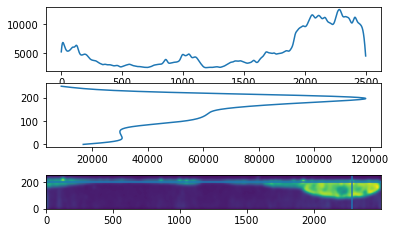

In [91]:
fig, axs = plt.subplots(nrows=3)
y_proj, x_proj = filt.sum(1), filt.sum(0)
axs[0].plot(np.arange(filt.shape[1]), x_proj)
axs[1].plot(y_proj, np.arange(filt.shape[0]))
pt = np.argmax(y_proj), np.argmax(x_proj)
axs[-1].imshow(filt, origin='lower')
axs[-1].axvline(pt[1])
axs[-1].axhline(pt[0])

In [112]:
pt_res0 = np.array(pt) * (2 ** lvl)
bbox = slice(pt_res0[0] - 100, pt_res0[0] + 100), slice(pt_res0[1] - 100, pt_res0[1] + 100)

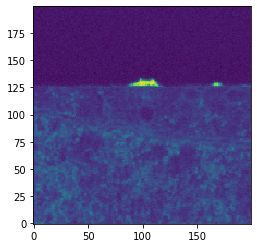

In [113]:
plt.imshow(data_pyr[0][1995][bbox].compute(scheduler='threads'), origin='lower')

In [114]:
samples = data_pyr[0][1995:1997].compute(scheduler='threads').astype('float32')

In [122]:
fixed_roi, moving = samples[0][bbox], samples[1][bbox]
v = napari.Viewer()
v.add_image(fixed - moving, name='fixed-moving')
v.add_image(farid(fixed) - farid(moving), name='edge filtered fixed-moving')

<Image layer 'edge filtered fixed-moving' at 0x2afdadcdb208>

In [118]:
sitk.ProcessObject_SetGlobalDefaultNumberOfThreads(1)

In [120]:
fixed.shape

(200, 200)

In [119]:
%%time
r_raw = sitkreg(fixed, moving)
r_edge = sitkreg(farid(fixed), farid(moving))

CPU times: user 420 ms, sys: 0 ns, total: 420 ms
Wall time: 412 ms


In [125]:
print(mismatch(fixed, moving))
print(mismatch(fixed, sitkapply(fixed, moving, r_raw)))
print(mismatch(fixed, sitkapply(fixed, moving, r_edge)))

61365.940075
62337.50420811813
62444.9685246424


In [123]:
v.add_image(fixed - sitkapply(fixed, moving, r_edge), name='fixed - reg')

<Image layer 'fixed - reg' at 0x2afdaee4fc18>

In [7]:
from skimage.registration import optical_flow_tvl1
of = optical_flow_tvl1(*samples)

In [16]:
coords = np.mgrid[:data.shape[1],:data.shape[2]].astype('float64')
coords_warp -= of

In [17]:
from skimage.transform import warp
from skimage.metrics import mean_squared_error as mse
print(mse(samples[0], warp(samples[1], coords, preserve_range=True)))
print(mse(samples[0], warp(samples[1], coords_warp, preserve_range=True)))

51526.5632513
30873.972078734456


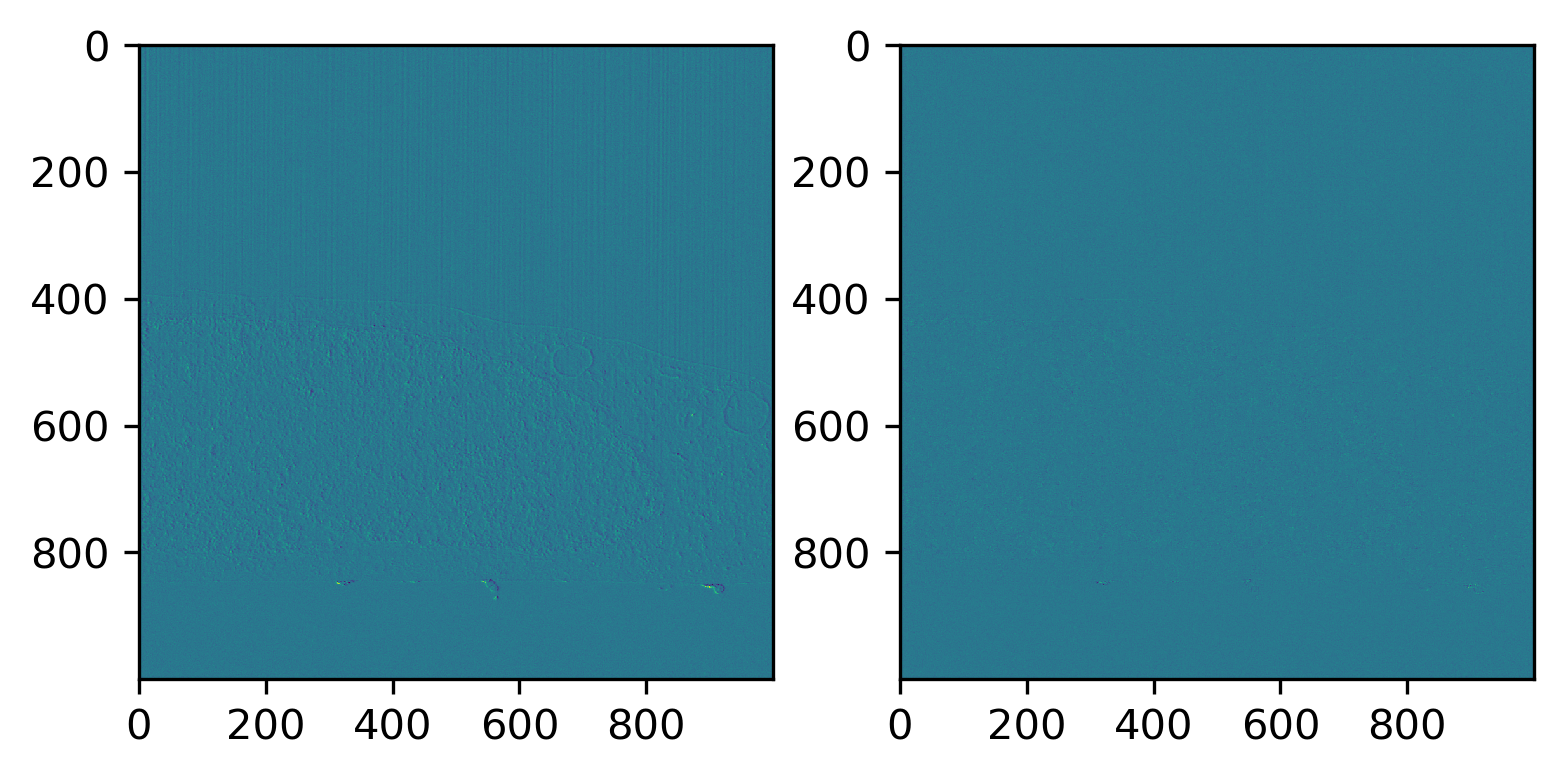

In [18]:
fig, axs= plt.subplots(dpi=300, ncols=2)
roi = slice(None), slice(-1000, None)

axs[0].imshow((samples[0] - warp(samples[1], coords, preserve_range=True, order=3))[roi])
axs[1].imshow((samples[0] - warp(samples[1], coords_warp, preserve_range=True, order=3))[roi], clim=axs[0].images[0].get_clim())

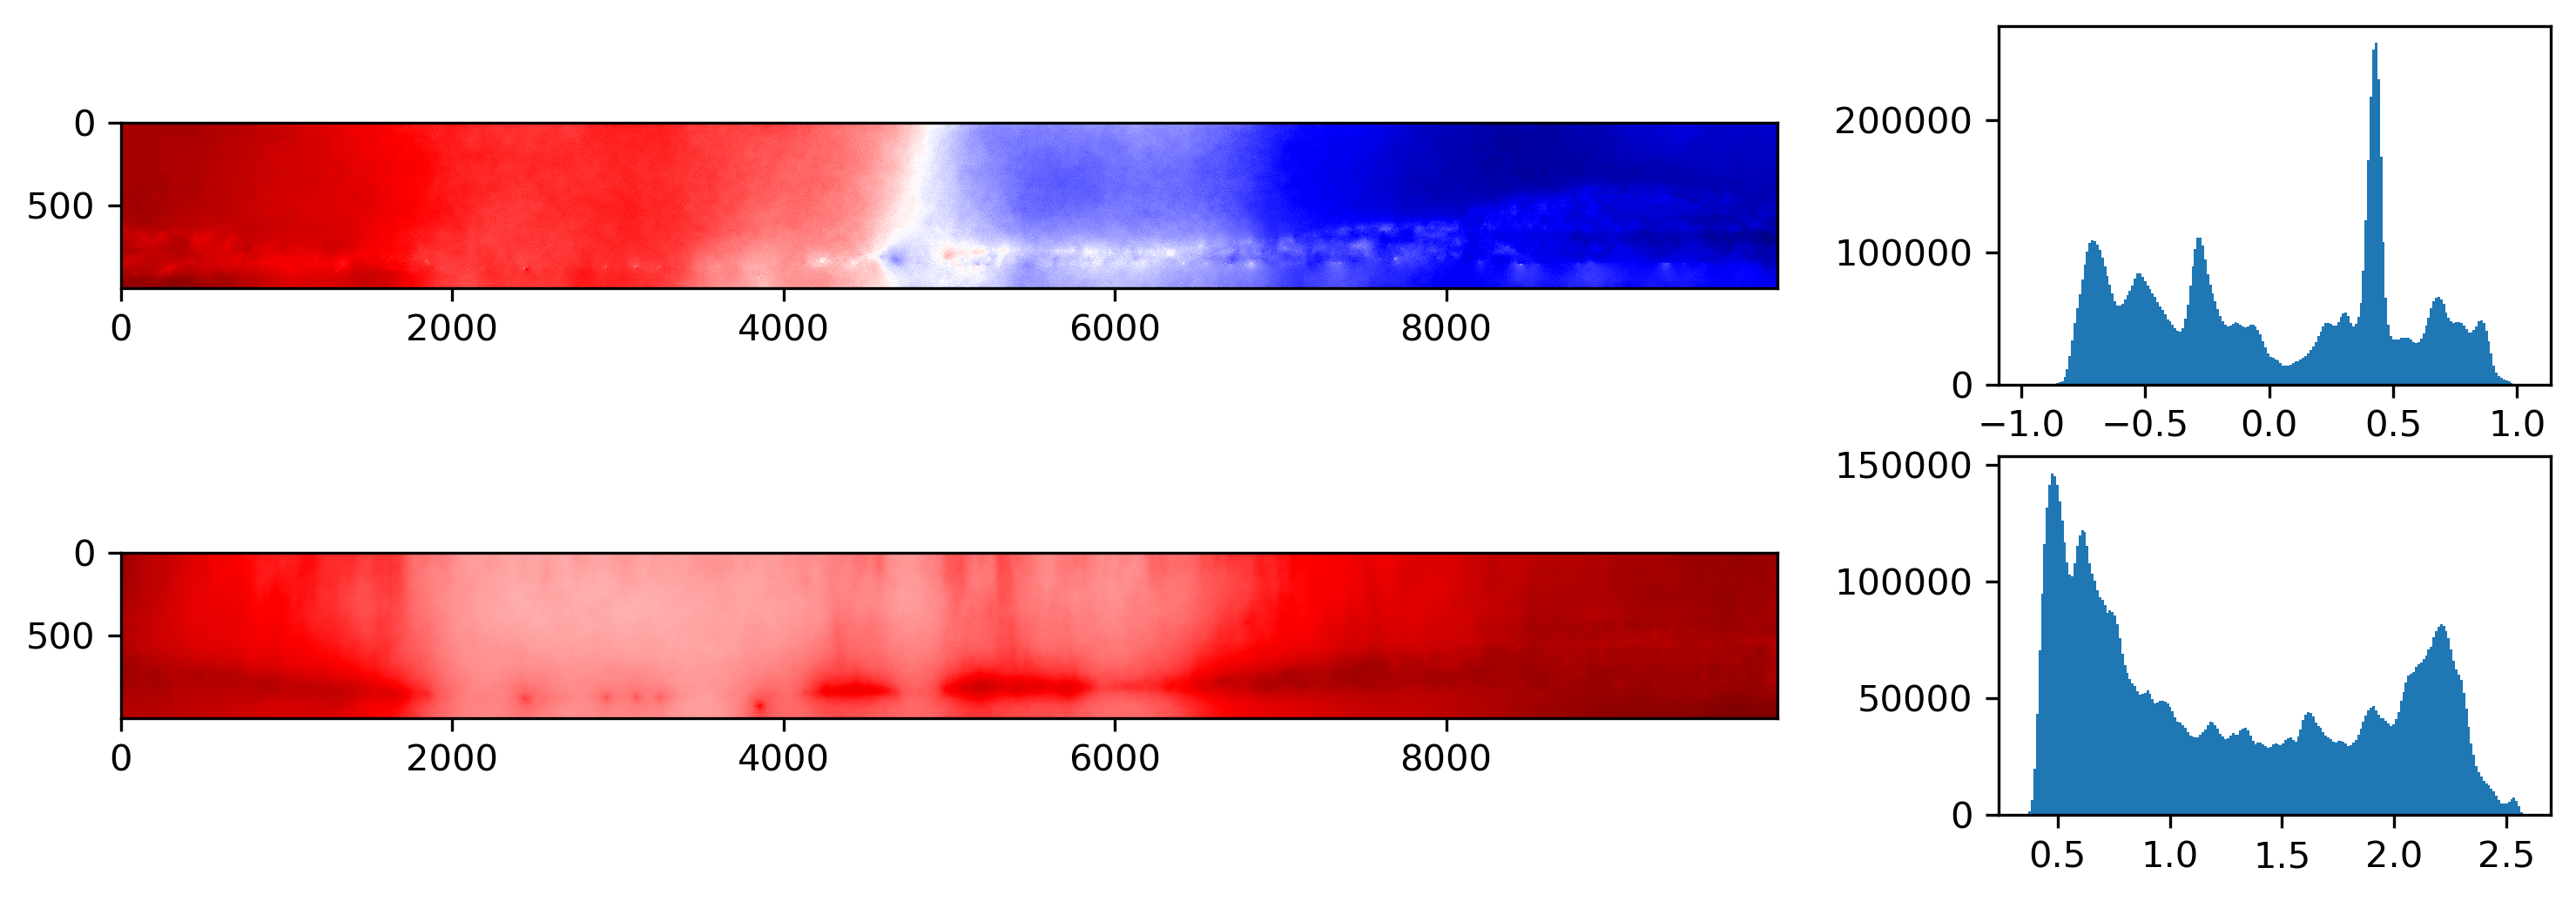

In [19]:
fig, axs = plt.subplots(dpi=300, figsize=(12,4), nrows=2, ncols=2, gridspec_kw=dict(width_ratios=(3,1)))
for ind in range(of.shape[0]):
    axs[ind][0].imshow(of[ind], clim=(-np.abs(of[ind]).max(), np.abs(of[ind]).max()) , cmap='seismic')
    axs[ind][1].hist(of[ind].ravel(), 200);

In [ ]:
# generate summary data
client.cluster.scale(20)
summary_inds = {}
summary = {}
summary_inds['z'] = slice(0, data.shape[0], 500)
summary_inds['x'] = slice(0, data.shape[2], 500)
summary['z'], summary['x'] = client.compute((data[summary_inds['z']], data[:,:,summary_inds['z']]), sync=True)
client.cluster.scale(0)

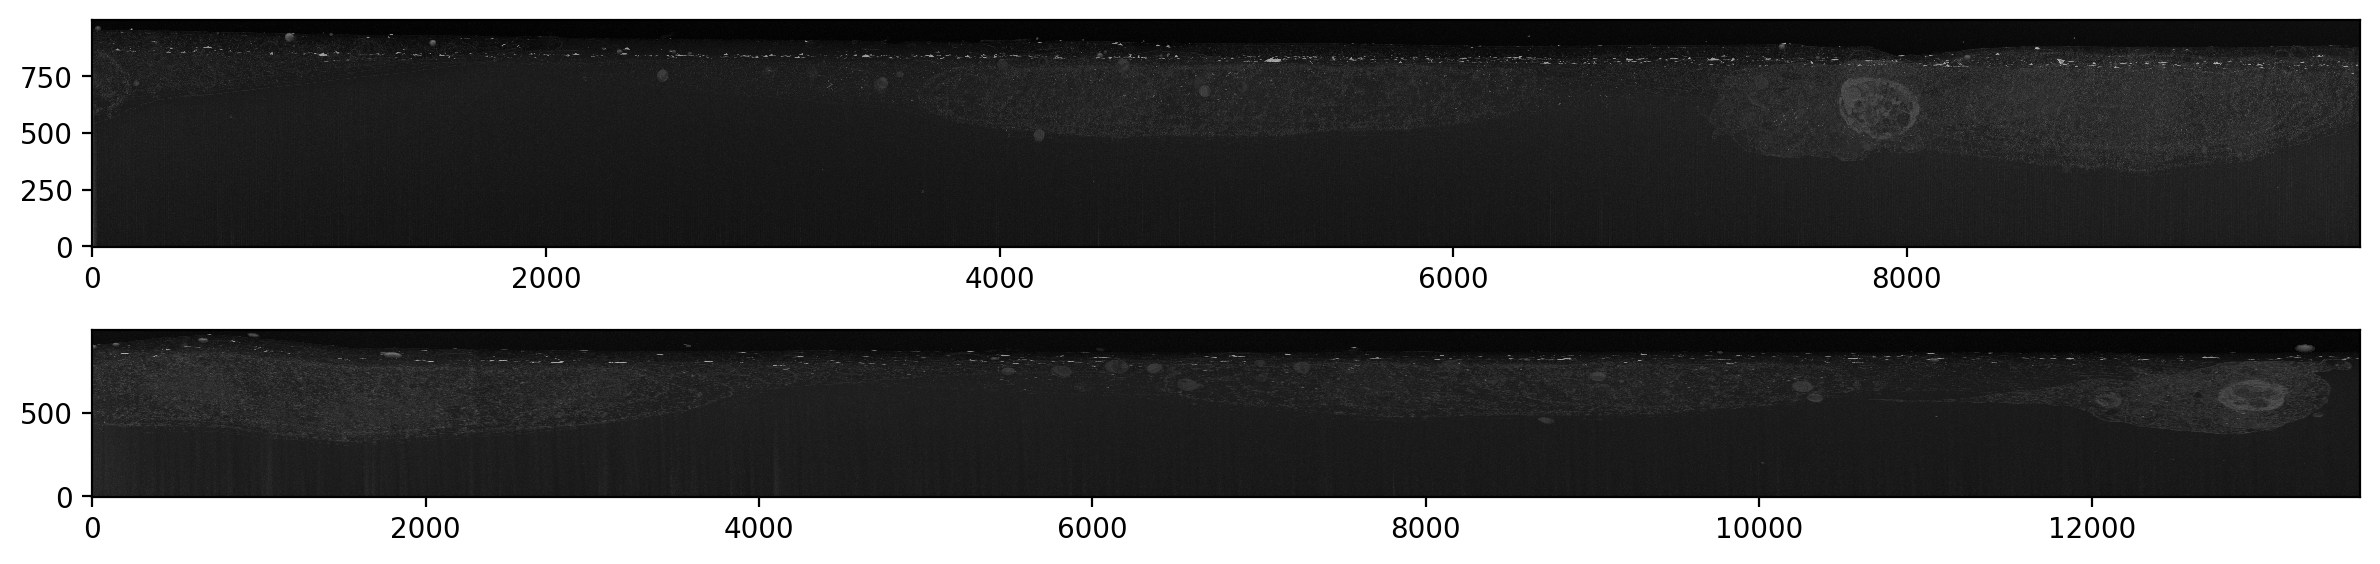

In [7]:
fig, axs = plt.subplots(dpi=200, figsize=(12,3), nrows=2)
axs[0].imshow(summary['z'].max(0), cmap='gray', origin='lower')
axs[1].imshow(summary['x'].T.max(0), cmap='gray', origin='lower')
fig.tight_layout()

In [58]:
from scipy.ndimage.filters import gaussian_filter
ds = (1,1,1)
interp_order = 3
crop = slice(None), slice(500,None), slice(None)
raw_dsk = data.map_blocks(lambda v: resizer(v, ds), dtype='float32')
def prefilt(v):
    return v.astype('float32')

roi_dsk = raw_dsk[crop].map_blocks(prefilt, dtype='float32')

In [53]:
scales = 2 ** np.arange(0, 12,2)
scales

array([   1,    4,   16,   64,  256, 1024])

In [59]:
dummy_shifts_dsk = da.from_array(np.array([[.5,.5]] * roi_dsk.shape[0]), chunks=(-1,-1))
dummy_shifted = roi_dsk.map_blocks(shifter, order=interp_order, shifts=dummy_shifts_dsk, cval=clims[0], dtype='float32')

In [60]:
client.cluster.scale(100)
errs_raw = [pairwise(mismatch, dummy_shifted[::s], axis=0) for s in scales] 
errs = client.compute(errs_raw, sync=True)
client.cluster.scale(0)

for s, err in zip(scales, errs):
    dlog[f'errs/multiscale/{s}'] = err

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://10.36.111.13:41388 remote=tcp://10.36.111.13:35118>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://10.36.111.13:41392 remote=tcp://10.36.111.13:35118>


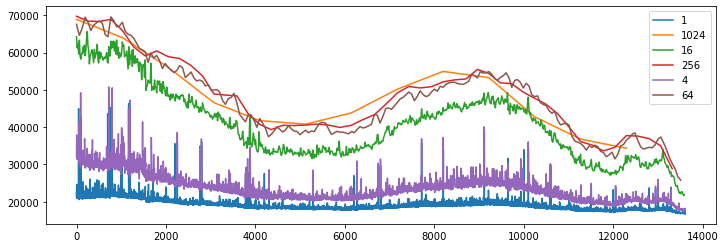

In [61]:
fig, axs =  plt.subplots(figsize=(12,4))
for scale, err in dlog['errs/multiscale'].items():
    x = np.arange(data.shape[0])[crop[0]][::int(scale)][:-1]
    axs.plot(x, err[:], label=scale)
axs.legend()

In [62]:
jq.start_workers(400)
regs = pairwise(estimate_translation, roi_dsk, axis=0)
res = regs.compute()
jq.stop_all_jobs()

raw_shifts = np.vstack([np.zeros((1,2)), np.array([-r.affine[:-1,-1] for r in res])])
dlog['shifts/raw'] = raw_shifts

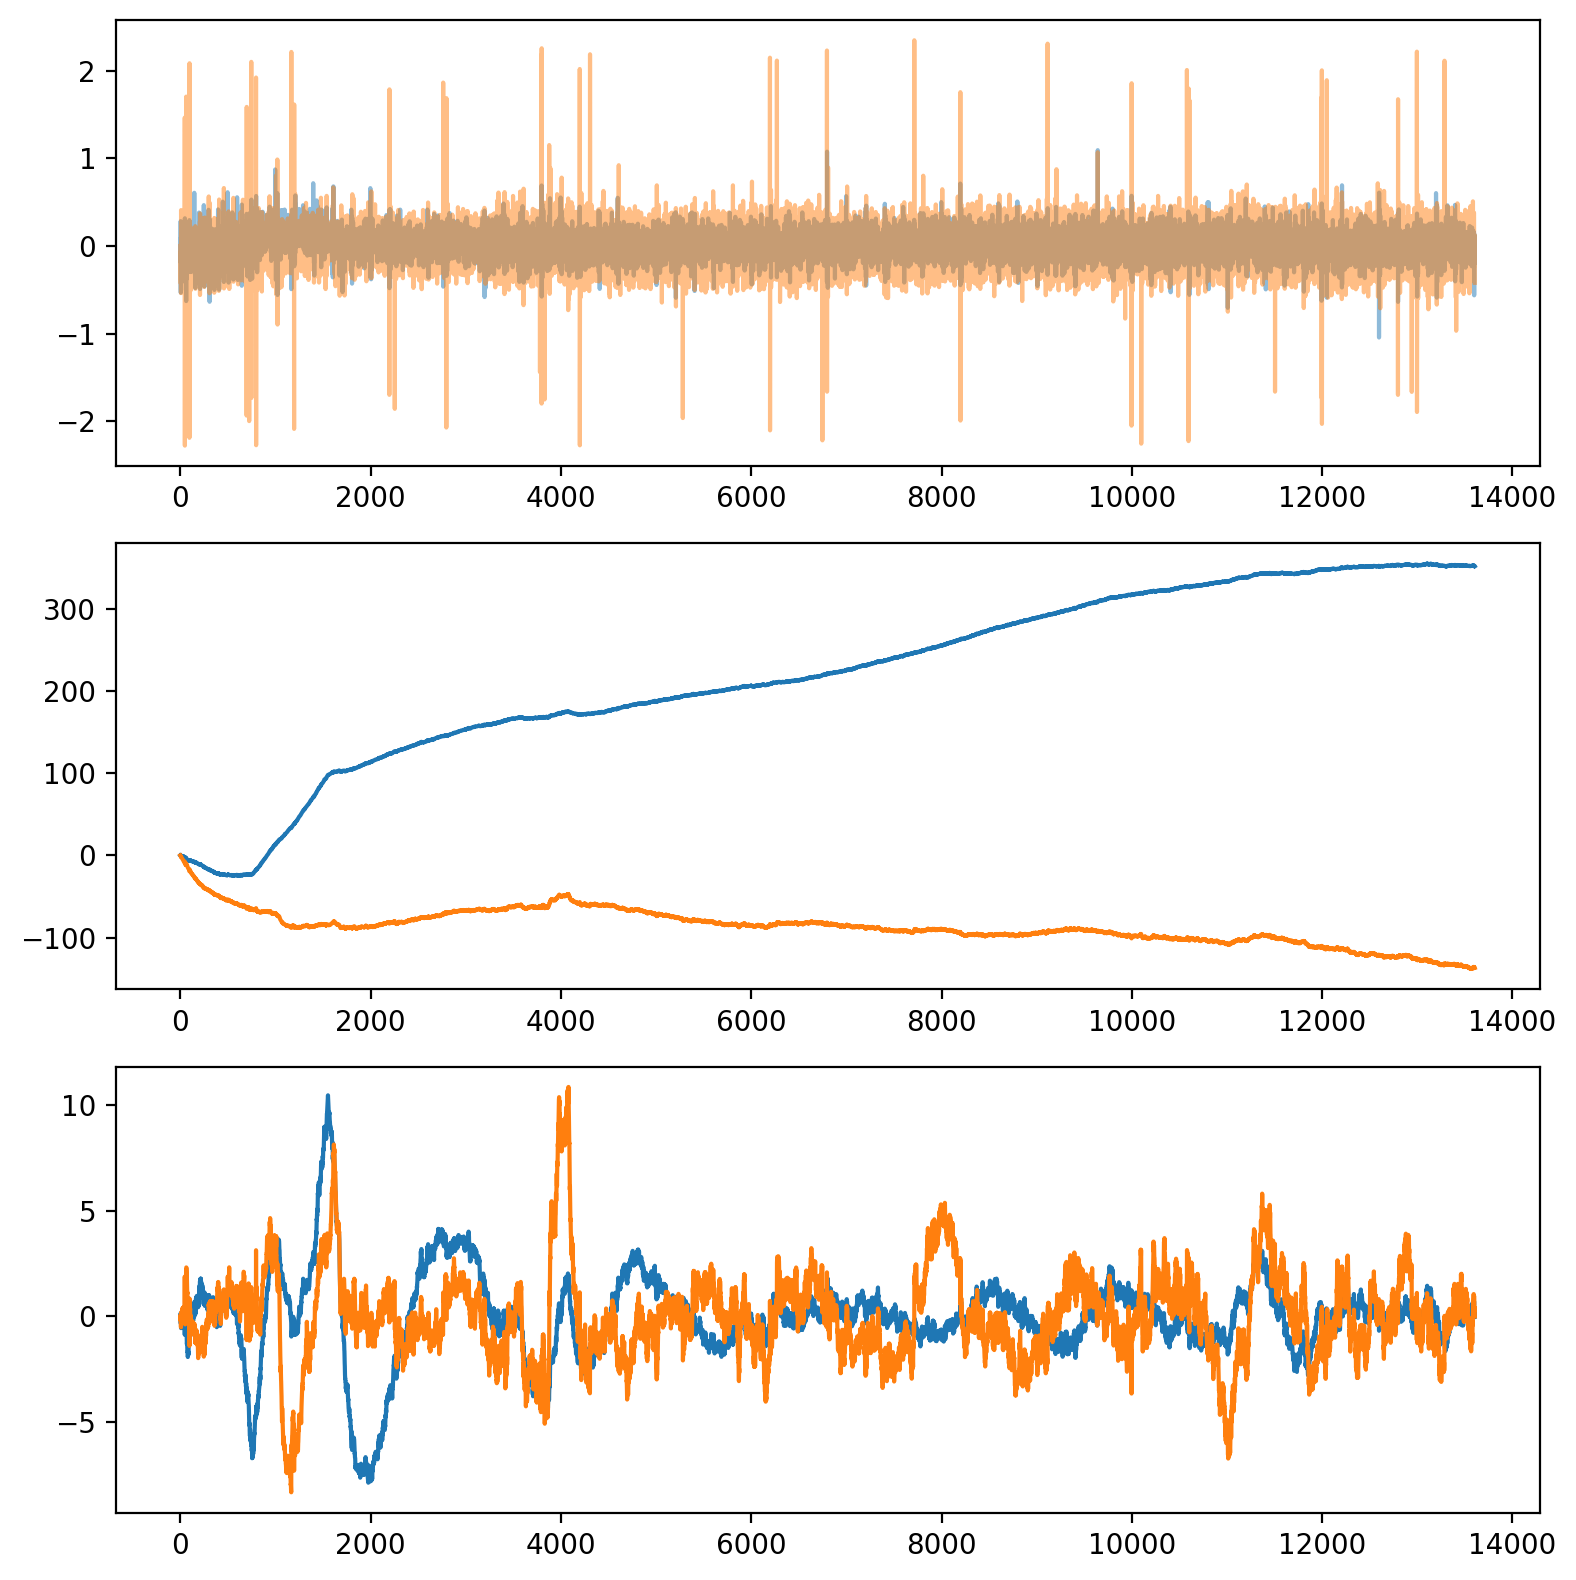

In [63]:
raw_shifts = dlog['shifts/raw'][crop[0]]
raw_shifts_det = detrend_spline(raw_shifts, t = np.arange(1, raw_shifts.shape[0], 1000))
accumulated_shifts = np.cumsum(raw_shifts,0)
accumulated_shifts_det = np.cumsum(raw_shifts_det, 0)

fig, axs = plt.subplots(dpi=200, nrows=3, figsize=(8,8))
axs[0].plot(raw_shifts, alpha=.5)
axs[1].plot(accumulated_shifts)
axs[2].plot(accumulated_shifts_det)
fig.tight_layout()

In [64]:
shifts_dsk = da.from_array(accumulated_shifts_det, chunks=(-1,-1))
shifted = roi_dsk.map_blocks(shifter, 
                             order=interp_order, 
                             shifts=shifts_dsk, 
                             cval=clims[0], 
                             dtype='float32')

In [ ]:
pu = np.floor(shifts_dsk.min(0).compute(scheduler='threads')).astype('int') - 1
pl = np.ceil(shifts_dsk.max(0).compute(scheduler='threads')).astype('int') + 1
jq.start_workers(100)
dlog['errs/reg'] = pairwise(mismatch, shifted[:,pl[0]:pu[0], pl[1]:pu[1]], axis=0).compute()
jq.stop_all_jobs()

In [ ]:
fig, axs = plt.subplots(dpi=200, figsize=(8,4))
axs.plot(dlog['errs/multiscale/1'], label='Before registration')
axs.plot(dlog['errs/reg'], label='After registration')
axs.set_ylabel('MSE')
axs.set_xlabel('Slice index')
axs.title.set_text(f'{exp_name} \n Error between adjacent images before and after registration \n (lower is better)')
axs.legend()

[]

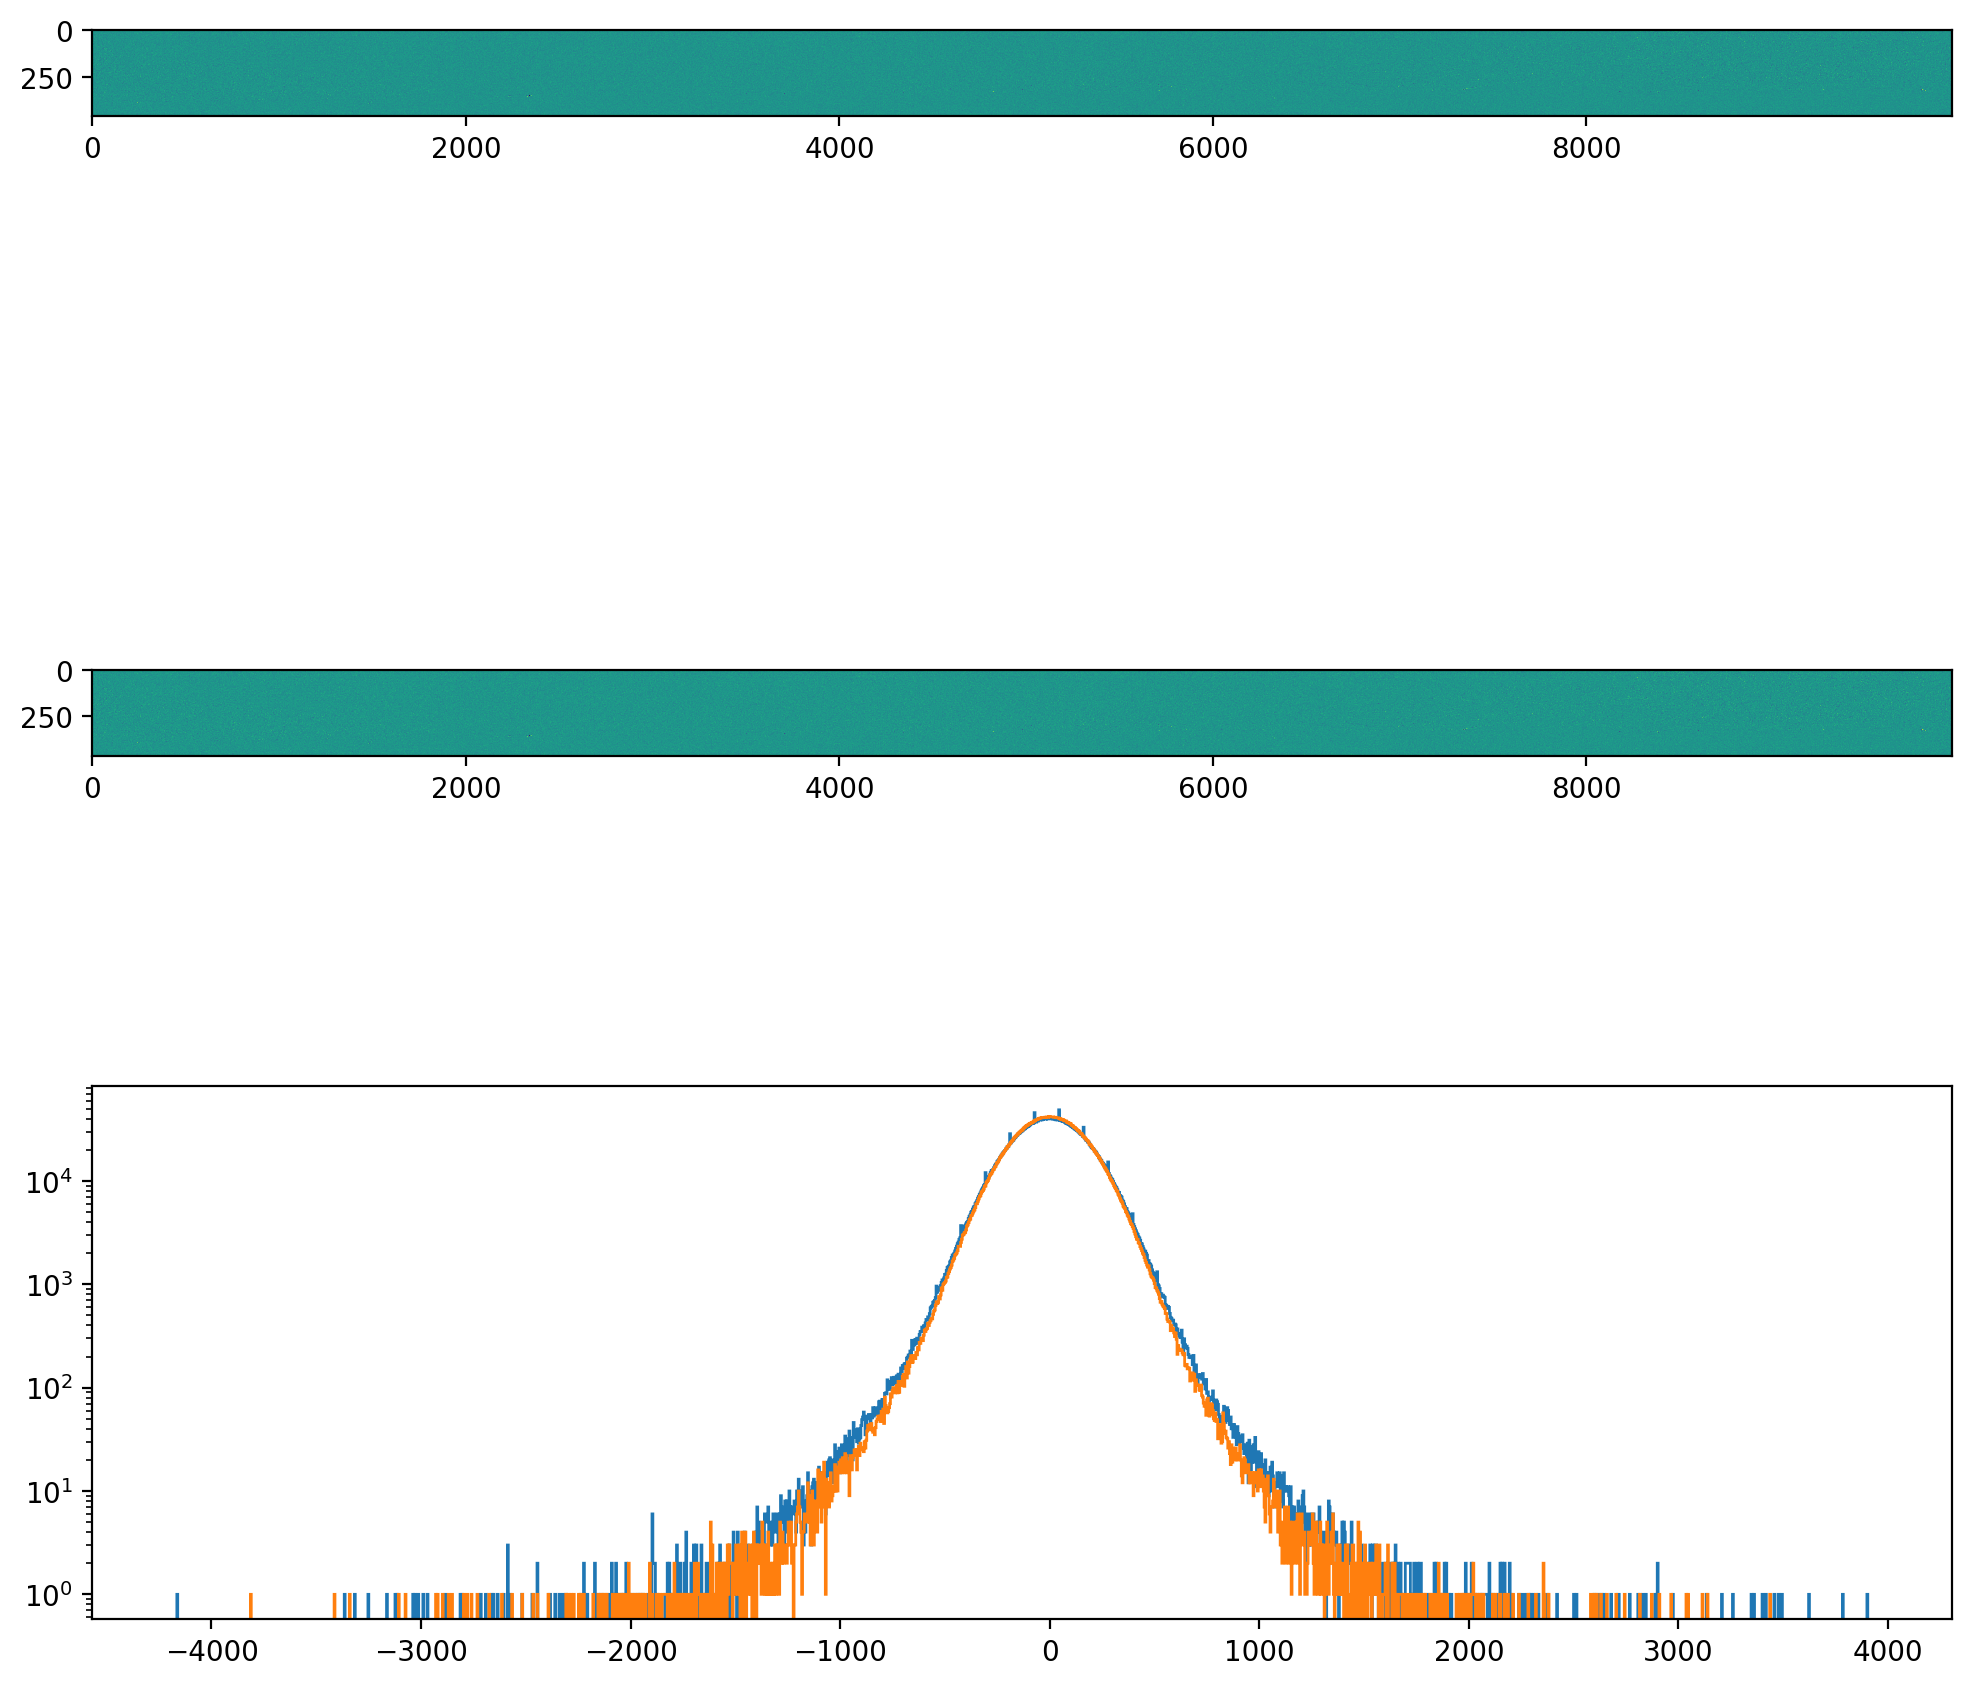

In [147]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import shift
fig, axs = plt.subplots(dpi=200, figsize=(12,12), nrows=3)
z_ = slice(0,2)
filt = lambda v: gaussian_filter(v, sigma=(0,0,0))
roi_ = slice(10,-10), slice(10,-10)
shifted_raw = filt(roi_dsk[z_].compute(scheduler='threads'))[:,roi_[0], roi_[1]]
shifted_tx = filt(shifted[0:2].compute(scheduler='threads'))[:,roi_[0], roi_[1]]
#shifted_tx = np.array([shifted_raw[0], 
#                       shift(shifted_raw[1], 
#                             accumulated_shifts_det[z_.start + 1],
#                             order=interp_order, 
#                             cval=clims[0])])


err_raw = np.diff(shifted_raw, axis=0).squeeze()[roi_]
err_tx = np.diff(shifted_tx, axis=0).squeeze()[roi_]

axs[0].imshow(err_raw)
axs[1].imshow(err_tx)
counts,bins, patches = axs[2].hist(err_raw.ravel(), 2000, histtype='step');
axs[2].hist(err_tx.ravel() , bins=bins, histtype='step');
#axs[2].set_xlim(np.percentile(err_raw, (0,90)))
axs[2].semilogy()

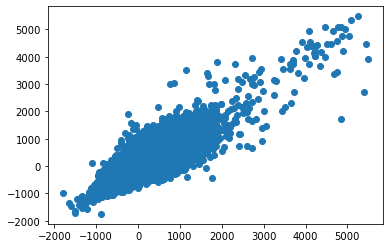

In [148]:
plt.plot(shifted_tx[0].ravel()[::10], shifted_tx[1].ravel()[::10],'o')

In [149]:
print(mismatch(*shifted_tx, metric='pearson'))
print(mismatch(*shifted_raw, metric='pearson'))

0.5938237049786386
0.5690572068225944


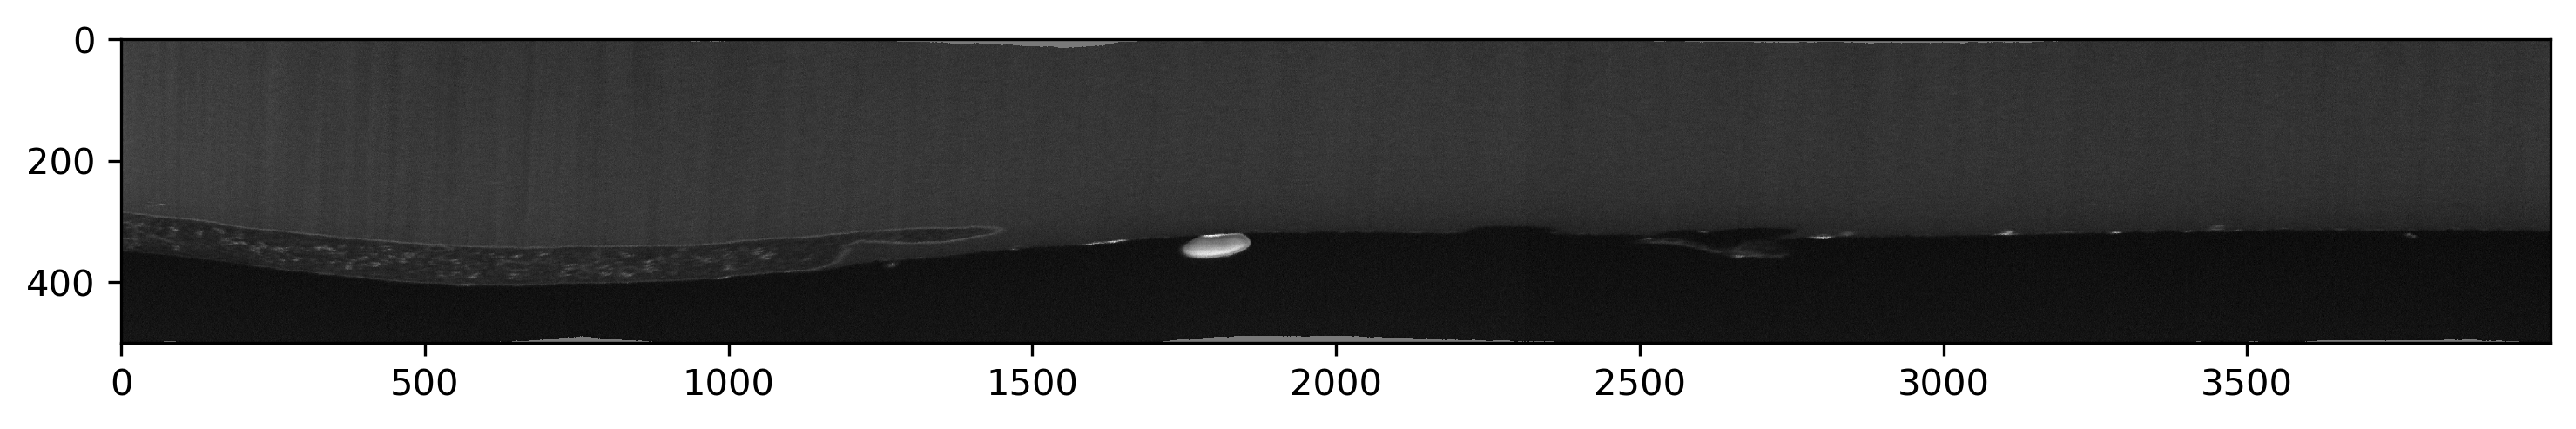

In [102]:
fig, axs= plt.subplots(dpi=300, figsize=(12,3))
axs.imshow(samples_reg_y[:4000,:,50].T, cmap='gray')

In [242]:
## tree-based long-range alignment

In [58]:
scales

array([   1,    4,   16,   64,  256, 1024])

In [ ]:
client.cluster.start_workers(100)
long_txs = da.compute([pairwise(estimate_translation, roi_dsk[::s], 0) for s in scales[1:]], sync=True) 
client.cluster.stop_all_jobs()

In [65]:
len(long_txs[0])

5

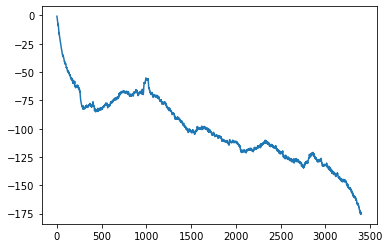

In [84]:

plt.plot(np.cumsum(np.array([-r.affine[1,-1] for r in long_txs[0][0]])))

In [326]:
samples_ = samples.compute(scheduler='threads')

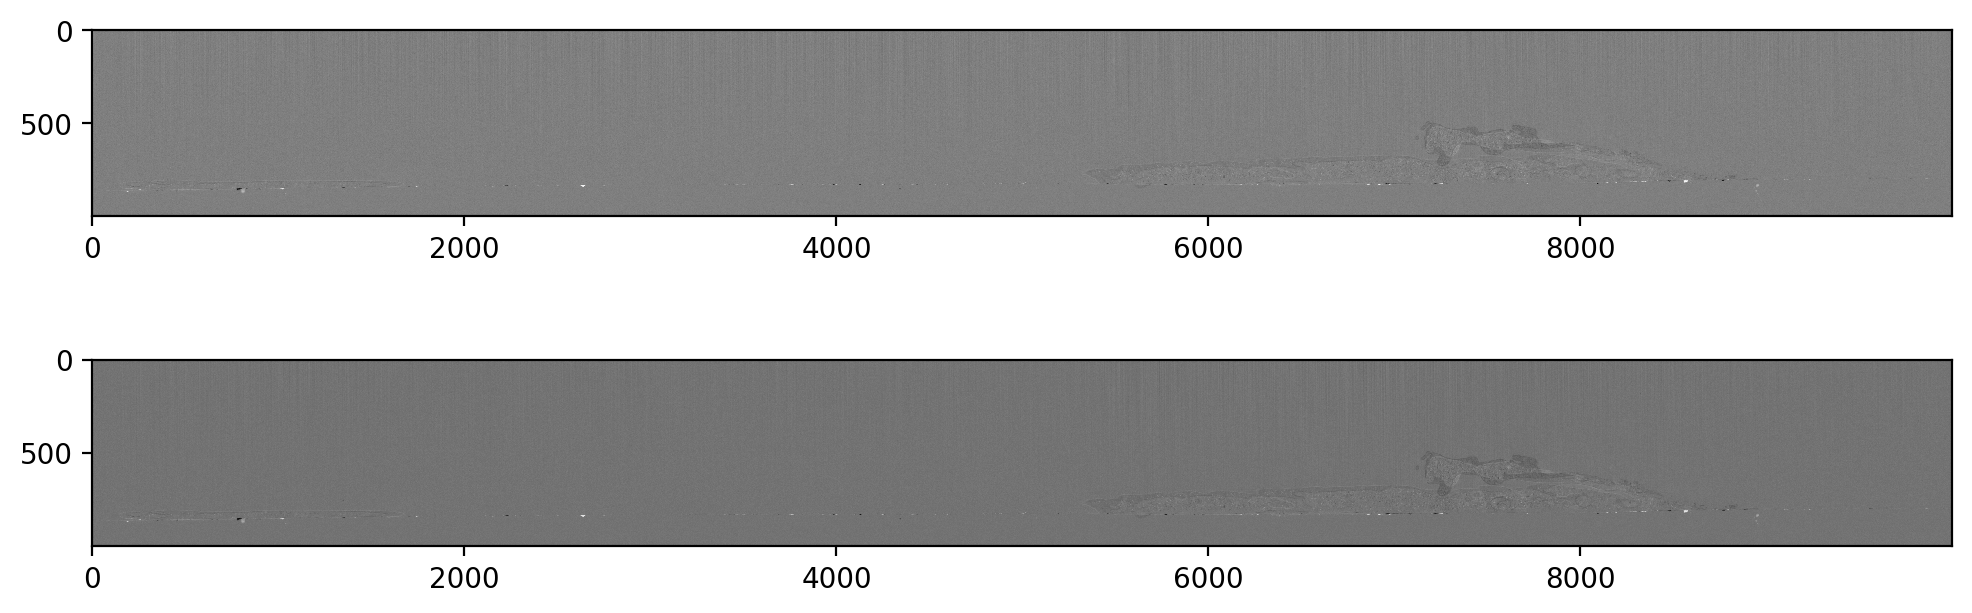

In [338]:
fig, axs = plt.subplots(dpi=200, figsize=(12,4), nrows=2)
ind = 58
axs[0].imshow((samples_[ind]-samples_[ind+1]), cmap='gray')
axs[1].imshow(samples_[ind]-long_txs[ind].transform(samples_[ind+1]), cmap='gray')

In [ ]:
levels = 

In [402]:
client.cluster.start_workers(50)
samples_reg, samples_raw = client.compute((shifted[6000:6100], roi_dsk[6000:6100]), sync=True)
client.cluster.stop_all_jobs()

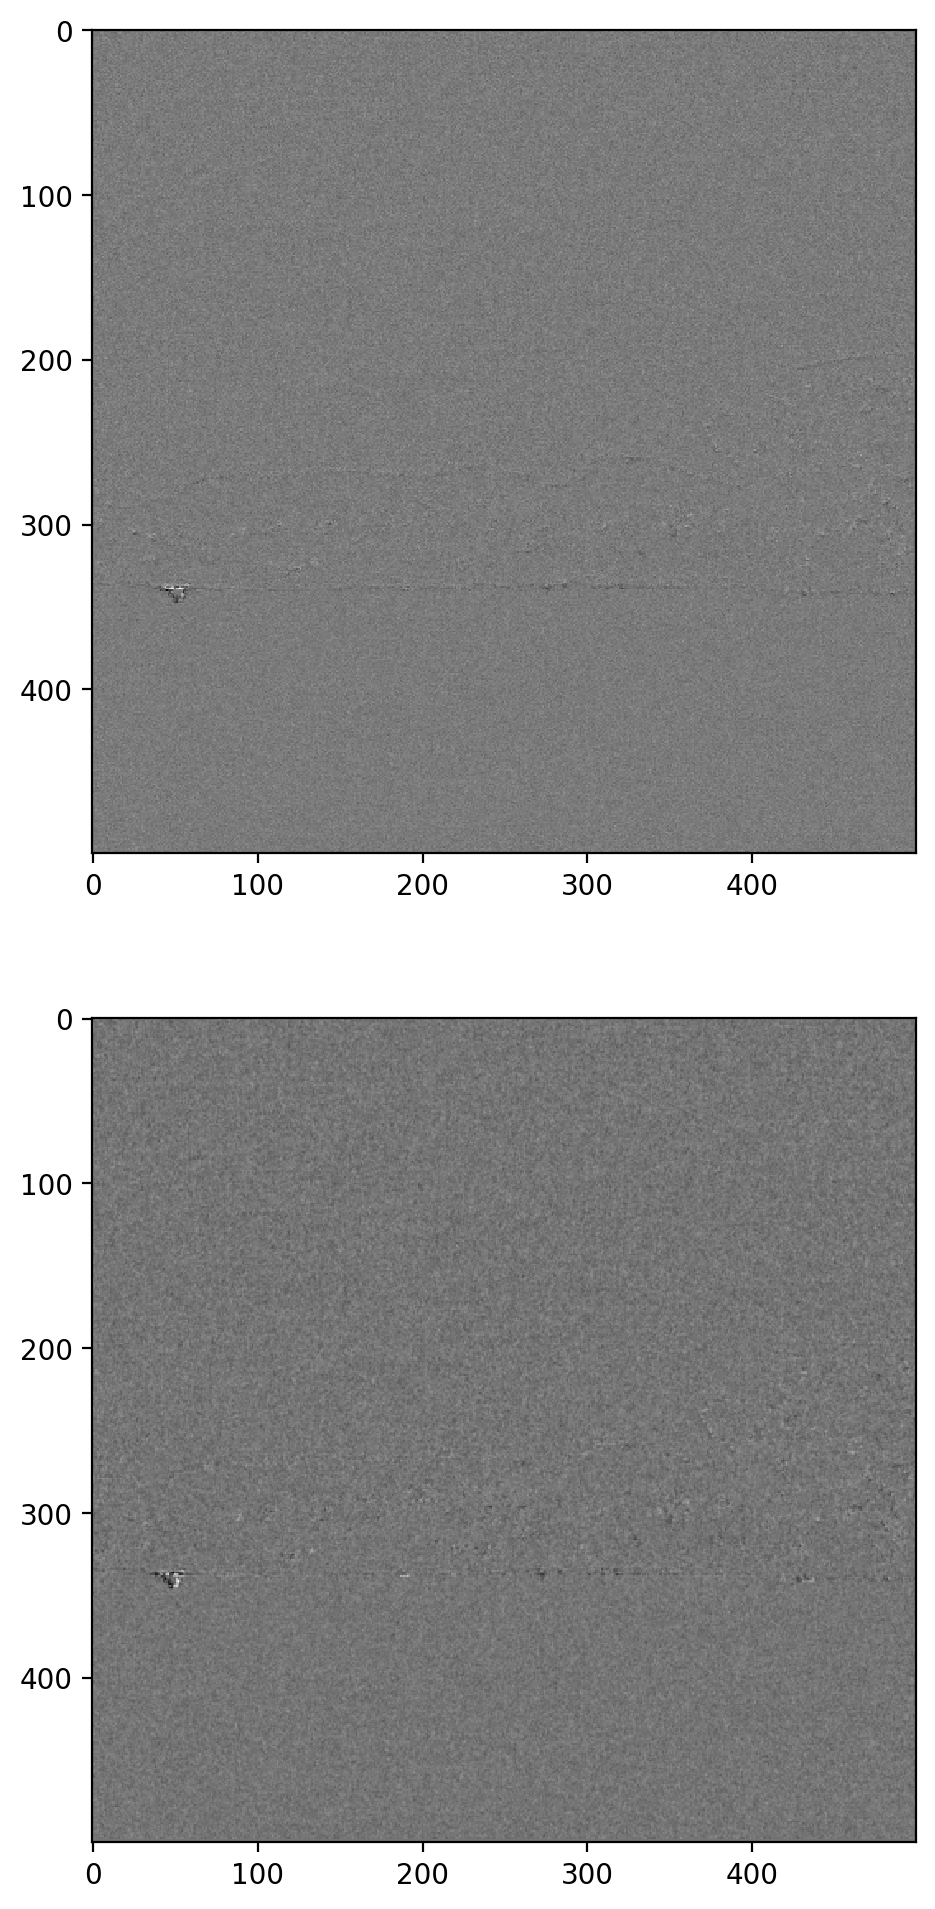

In [409]:
fig, axs = plt.subplots(dpi=200, figsize=(12,12), nrows=2)
idx_1 = (20, slice(None), slice(2000,2500))
idx_2 = (idx_1[0] + 1, idx_1[1], idx_1[2])
axs[0].imshow(samples_raw[idx_1] - samples_raw[idx_2], cmap='gray')
axs[1].imshow(samples_reg[idx_1] - samples_reg[idx_2], cmap='gray')

In [433]:
# Local translation estimates

In [168]:
im1, im2 = samples_raw[idx_1[0]], samples_raw[idx_2[0]]
delf, shape = tiled_pairwise(im1, im2, (50,100), lambda v: estimate_translation(v[0], v[1]))
weights, shape = tiled_pairwise(im1, im2, (50,100), lambda v: (v.mean(), v.std())

In [169]:
client.cluster.start_workers(20)
txs = np.array(da.compute(np.array(delf).reshape(shape).tolist())).squeeze()
ws = np.array(da.compute(np.array(weights).reshape(shape).tolist())).squeeze()
client.cluster.stop_all_jobs()

(-5, 5)

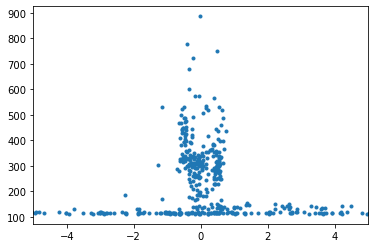

In [219]:
plt.scatter((np.array([r.affine[0,-1] for r in res.ravel()]).reshape(res.shape)).ravel(),ws[:,:,1].ravel(), marker='.')
plt.xlim(-5,5)

(-3, 3)

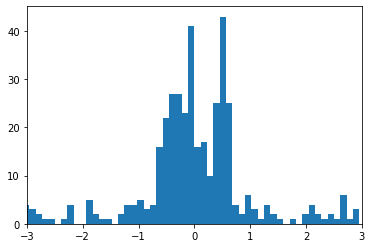

In [204]:
plt.hist((np.array([r.affine[0,-1] for r in res.ravel()]).reshape(res.shape)).ravel(), 500);
plt.xlim(-3,3)

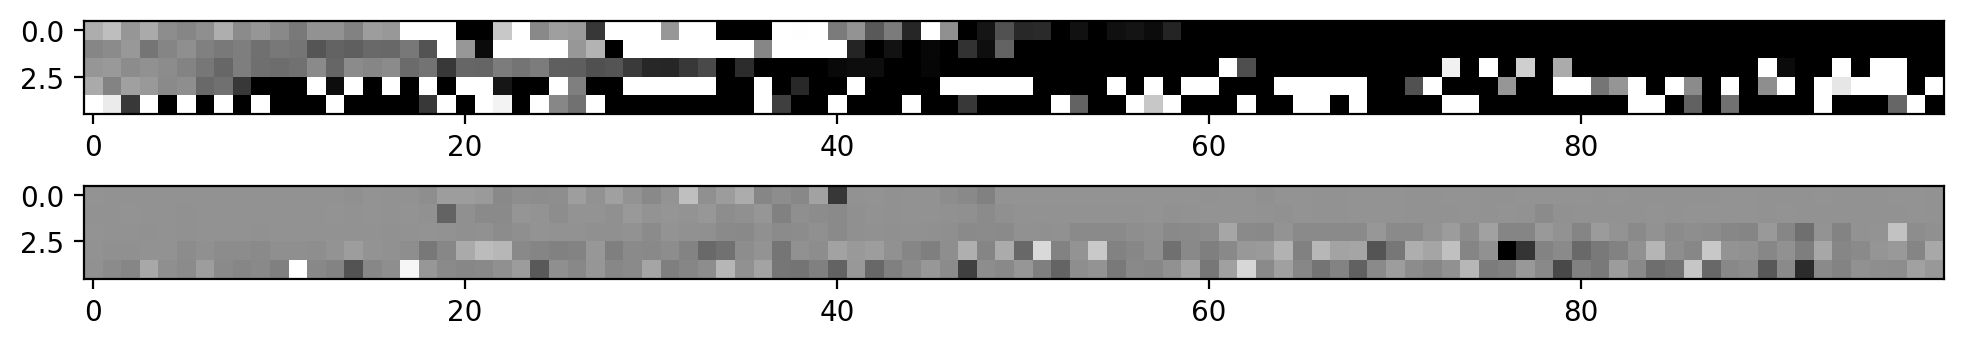

In [196]:
from skimage.exposure import rescale_intensity as rescale
fig, axs = plt.subplots(dpi=200, figsize=(12,2), nrows=2)
std_weights = rescale(ws[:,:,1], out_range=(0,1))
axs[0].imshow(np.array([r.affine[0,-1] for r in res.ravel()]).reshape(res.shape), cmap='gray', clim=(0,1))
axs[1].imshow(np.array([r.affine[1,-1] for r in res.ravel()]).reshape(res.shape), cmap='gray')

In [86]:
def overlay(colors=('gray','cyan'), **kwargs):
    viewer = napari.view(**kwargs)
    for ind,v in enumerate(viewer.layers):
        v.blending='additive'
        v.colormap=colors[ind]
    return viewer

In [35]:
def as_chunks(dar):
    from itertools import product
    from numpy import cumsum,array
    from dask.array import stack
    # create a list of lists of the first indices of each chunk
    origins = list(product(*[cumsum(t) - t[0] for t in dar.chunks]))
    # the increment of each chunk. assumes uniform chunking.
    steps = tuple(array(dar.chunksize))
    # create list of "atomic" slices, i.e. each slice indexes a single chunk entirely
    slices = []
    for origin in origins:
        slices.append(tuple((slice(item, item + steps[dim])) for dim,item in enumerate(origin)))
    
    # return the shape of the original data reduced to each chunk
    new_shape = (*(len(l) for l in dar.chunks),)
    result = [dar[i] for i in slices]
    
    return result, new_shape

def split_by_chunks(a):
    for i in np.ndindex(a.numblocks):
        yield a.blocks[i]

def tiled_pairwise(im1, im2, chunks, func):
    import dask.array as da
    from dask.delayed import delayed
    delf = delayed(func)
    dars = da.stack([da.from_array(im1, chunks=chunks), 
                     da.from_array(im2, chunks=chunks)]).rechunk((-1, *chunks))
    
    blocks, shape = as_chunks(dars)
    result = [delf(i) for i in blocks]
    
    return result, shape

im1 = np.zeros((10,10))
im1[0,0] = 3
im2 = np.ones((10,10))
chunks = (2,2)
dars = da.stack([da.from_array(im1, chunks=chunks), 
                 da.from_array(im2, chunks=chunks)]).rechunk((-1, *chunks))

blocks, shape = as_chunks(dars)